In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import statsmodels.formula.api as smf


from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes

from shapely import wkt

import seaborn as sns
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

import matplotlib.patches as mpatches
import colorsys
from matplotlib.colors import to_hex
import contextily as ctx


import contextily as ctx
import seaborn as sns

demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)

full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')
lr = full_results[full_results['candidate'] == 'Lincoln Restler']

ae = pd.read_csv('../../cc_election_cleaning/ae_precincts.csv')
av = pd.read_csv('../../cc_election_cleaning/additional_variables.csv')
fwe = pd.read_csv('../data/finance_with_ethnicity.csv')
f_plus = pd.read_csv('../../council_campaign_finance/data/iwrl_plus.csv')
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')

p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
wp_cols.remove('w2cop')
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip']
wp_cols = [col for col in wp_cols if col not in to_remove]
demo_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21']

lr = gpd.GeoDataFrame(lr,geometry=lr['geometry'].apply(wkt.loads))
lr = lr.set_crs(epsg=2263, allow_override=True)
co_3857 = lr.to_crs(epsg=3857)


In [14]:
import statsmodels.formula.api as smf

In [2]:
all_rounds = pd.read_csv('../../cc_election_cleaning/all_rounds_results/district_33.csv')

In [3]:
aal = pd.read_csv('../../cc_election_cleaning/precincts_leins.csv')
yd = pd.read_csv('../../cc_election_cleaning/yiddish_precincts.csv')
dt = pd.read_csv('../../cc_election_cleaning/degree_type.csv')

In [4]:
full_results[full_results['district'] == 33].groupby('candidate')['vote_share'].mean()

candidate
217576.0                  0.664950
217616.0                  0.582534
217802.0                  1.346093
217890.0                  2.199116
217941.0                  0.538006
218139.0                  0.319267
218600.0                  0.840094
218601.0                  0.494614
April Somboun             4.944753
Ben Solotaire             2.453130
Elizabeth E. Adams       20.491336
Lincoln Restler          51.132343
Sabrina N. Gates          6.230455
Stu Sherman               3.964566
Toba Potosky              5.189346
Victoria E. Cambranes     7.105268
Write-in                  0.845148
overvote                  0.654886
Name: vote_share, dtype: float64

In [34]:
full_results[full_results['district'] == 33].head()

Precinct   vote  total_vote_precinct  vote_share  ed_name  \
16458  AD: 50 ED: 001  207.0                237.0   87.341772    50001   
16459  AD: 50 ED: 001    8.0                237.0    3.375527    50001   
16460  AD: 50 ED: 001    5.0                237.0    2.109705    50001   
16461  AD: 50 ED: 001    5.0                237.0    2.109705    50001   
16462  AD: 50 ED: 001    4.0                237.0    1.687764    50001   

       winner  rank  district              candidate     matched_name  ...  \
16458    True   1.0        33        Lincoln Restler  Lincoln Restler  ...   
16459   False   2.0        33     Elizabeth E. Adams              NaN  ...   
16460   False   3.0        33            Stu Sherman              NaN  ...   
16461   False   4.0        33  Victoria E. Cambranes              NaN  ...   
16462   False   5.0        33       Sabrina N. Gates              NaN  ...   

       rv21italp   pg20jrbp   pg20djtp  dpp20bs  adams213p  garcia213p  \
16458   0.325468  27.524736  70.144119     68.0  79.270073   12.262774   
16459   0.325468  27.524736  70.144119     68.0  79.270073   12.262774   
16460   0.325468  27.524736  70.144119     68.0  79.270073   12.262774   
16461   0.325468  27.524736  70.144119     68.0  79.270073   12.262774   
16462   0.325468  27.524736  70.144119     68.0  79.270073   12.262774   

       winda21p  perc_retail  perc_finance  perc_healthcare  
16458       0.0    13.661972      3.615023        15.446009  
16459       0.0    13.661972      3.615023        15.446009  
16460       0.0    13.661972      3.615023        15.446009  
16461       0.0    13.661972      3.615023        15.446009  
16462       0.0    13.661972      3.615023        15.446009  

[5 rows x 77 columns]

In [4]:
lr.columns

Index(['Precinct', 'vote', 'total_vote_precinct', 'vote_share', 'ed_name',
       'winner', 'rank', 'district', 'candidate', 'matched_name',
       'kmode_cluster', 'member', 'ElectDist_x', 'ML4', 'ML6', 'ML5', 'ML2',
       'ML7', 'ML3', 'ML1', 'district_cluster', 'ElectDist_y', 'Shape_Leng',
       'Shape_Area', 'geometry', 'min_noise', 'max_noise',
       'summer_noise_complaints', 'min_arrests', 'max_arrests', 'density',
       'ldensity', 'p21own', 'p21rent', 'mhhi21', 'mean_noise', 'mean_arrests',
       'living_alone_ratio', 'same_sex_ratio', 'black_nys_ratio',
       'black_fb_ratio', 'white_transplant_ratio', 'femHHH_ratio',
       'drive_ratio', 'train_ratio', 'walk_ratio', 'bike_ratio', 'wfh_ratio',
       'bus_ratio', 'hh21olongp', 'h21p', 'nha21p', 'nhb21p', 'nhw21p',
       'mex21p', 'prican21p', 'domin21p', 'colomb21p', 'kor21p', 'chin21p',
       'venez21p', 'hh21op', 'hh21rc', 'range_of_arrests', 'range_of_noise',
       'cvap21bapp', 'rv21irp', 'rv21italp', 'pg20jrbp'

In [5]:
demo_occ = lr[['vote_share','ed_name','nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21','venez21p','chin21p',
                 'kor21p','colomb21p','domin21p','prican21p','mex21p','white_transplant_ratio','adams213p','winda21p', 
                 'rv21irp', 'rv21italp','pg20djtp']].merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')
demo_occ = demo_occ.merge(ae[['ElectDist','ind21p','bang21p','pak21p','filip21p']],on = 'ElectDist',how='left')
demo_occ = demo_occ.merge(av,on='ElectDist',how='left')
demo_occ = demo_occ.merge(yd,on = 'ElectDist', how='left')
demo_occ = demo_occ.merge(dt,on = 'ElectDist', how='left')
demo_occ = demo_occ.merge(aal[['ElectDist','tl_count']], on='ElectDist', how='left')

In [6]:
demo_occ['log_mhhi21'] = np.log(demo_occ['mhhi21'])

In [7]:
demo_occ['white_natives'] = demo_occ['nhw21p'] - demo_occ['white_transplant_ratio'] 

In [8]:
test_cols = ['vote_share','pg20djtp','rateE','nhw21p','nhb21p','h21p','nha21p','cvap21bapp','log_mhhi21','venez21p','chin21p','kor21p','colomb21p','domin21p','prican21p',
'mex21p','white_transplant_ratio','ind21p','bang21p','pak21p','filip21p','greek21p','arab21p',
'fb21bdp','fb21drp','hh21bop','tl_count','adams213p', 'rv21irp', 'rv21italp','st_hu','TOTAL_HUMD_pct','TOTAL_BIZE_pct'] + wp_cols

In [9]:
cor_matrix = demo_occ[test_cols].corr()
cor_matrix.dropna(subset=('vote_share'),inplace=True)
cor_matrix.sort_values(by='vote_share', ascending=False)

vote_share  pg20djtp     rateE    nhw21p    nhb21p  \
vote_share                1.000000  0.865675  0.773031  0.555313 -0.274397   
pg20djtp                  0.865675  1.000000  0.831290  0.533423 -0.262869   
adams213p                 0.817656  0.888535  0.788231  0.244466  0.074077   
rateE                     0.773031  0.831290  1.000000  0.509971 -0.255921   
w2oadp                    0.738135  0.828255  0.746029  0.445117 -0.199851   
w2edup                    0.625652  0.731200  0.640467  0.281339  0.033695   
nhw21p                    0.555313  0.533423  0.509971  1.000000 -0.819232   
tl_count                  0.438249  0.467873  0.515343  0.370543 -0.115341   
w2hsp                     0.408292  0.493643  0.535449 -0.018772  0.216851   
w2emrp                    0.331280  0.397494  0.352668  0.130138 -0.093947   
w2tranp                   0.331190  0.486849  0.295234  0.043305  0.041218   
w2bgp                     0.316533  0.370727  0.212322 -0.116440  0.175261   
w2matp                    0.308218  0.319402  0.109970  0.048887  0.112523   
w2farmp                   0.261128  0.269162  0.388580  0.210022 -0.093157   
TOTAL_BIZE_pct            0.260838  0.323857  0.546209  0.122659 -0.138401   
w2salep                   0.251761  0.348897  0.362258  0.186389 -0.145134   
w2ffp                     0.171844  0.210628 -0.008601 -0.205445  0.264320   
domin21p                  0.145127  0.204197  0.086935 -0.311088  0.175251   
w2conp                    0.137661  0.226572  0.069781  0.177391 -0.004955   
bang21p                   0.047138  0.177083 -0.018483 -0.061857  0.012636   
w2foodp                   0.046013  0.076722  0.056867 -0.015855  0.051248   
fb21drp                   0.034981  0.137322 -0.008471 -0.403606  0.274983   
w2pservep                 0.021613  0.064206 -0.063920 -0.064037  0.044524   
w2copp                   -0.003807  0.011044 -0.151144 -0.111516  0.165066   
w2cossp                  -0.025303 -0.091360 -0.002042 -0.097550  0.174283   
pak21p                   -0.096438 -0.152174 -0.141139 -0.069117  0.014300   
w2htp                    -0.103467 -0.183383 -0.182497 -0.022417 -0.049361   
prican21p                -0.106900 -0.049930 -0.120456 -0.600116  0.555493   
arab21p                  -0.107078 -0.160702 -0.116999  0.030617 -0.073717   
hh21bop                  -0.122139 -0.208868 -0.158077 -0.019090  0.145895   
w2scip                   -0.145456 -0.199817 -0.126265  0.047775 -0.066715   
st_hu                    -0.155514 -0.125941 -0.002919  0.105622 -0.193736   
mex21p                   -0.157225 -0.191254 -0.100302 -0.254715  0.130618   
w2prodp                  -0.172449 -0.097844  0.007117 -0.280858  0.183696   
w2aep                    -0.200908 -0.288566 -0.178152  0.058303 -0.183362   
venez21p                 -0.215934 -0.238932 -0.222059 -0.180411  0.041000   
fb21bdp                  -0.220521 -0.132652 -0.155052 -0.334530  0.166522   
TOTAL_HUMD_pct           -0.236836 -0.210429 -0.058093  0.046444 -0.158606   
h21p                     -0.245273 -0.162627 -0.254884 -0.705438  0.468225   
nhb21p                   -0.274397 -0.262869 -0.255921 -0.819232  1.000000   
greek21p                 -0.301562 -0.333311 -0.266152 -0.008108 -0.164556   
colomb21p                -0.306216 -0.225538 -0.209649 -0.253560 -0.044692   
kor21p                   -0.316209 -0.339901 -0.218361 -0.288790  0.101810   
filip21p                 -0.353718 -0.347106 -0.301377 -0.128973  0.000704   
w2lawp                   -0.392045 -0.499212 -0.353986 -0.078652  0.008820   
chin21p                  -0.402693 -0.470588 -0.375276 -0.451324  0.292957   
w2cmp                    -0.459435 -0.457197 -0.388073 -0.198242  0.035745   
log_mhhi21               -0.466596 -0.399897 -0.460137 -0.156245 -0.022461   
w2mgtp                   -0.476665 -0.500035 -0.347718 -0.033216 -0.247818   
ind21p                   -0.485151 -0.471590 -0.360683 -0.423175  0.047530   
w2banp                   -0.491671 -0.523172 -

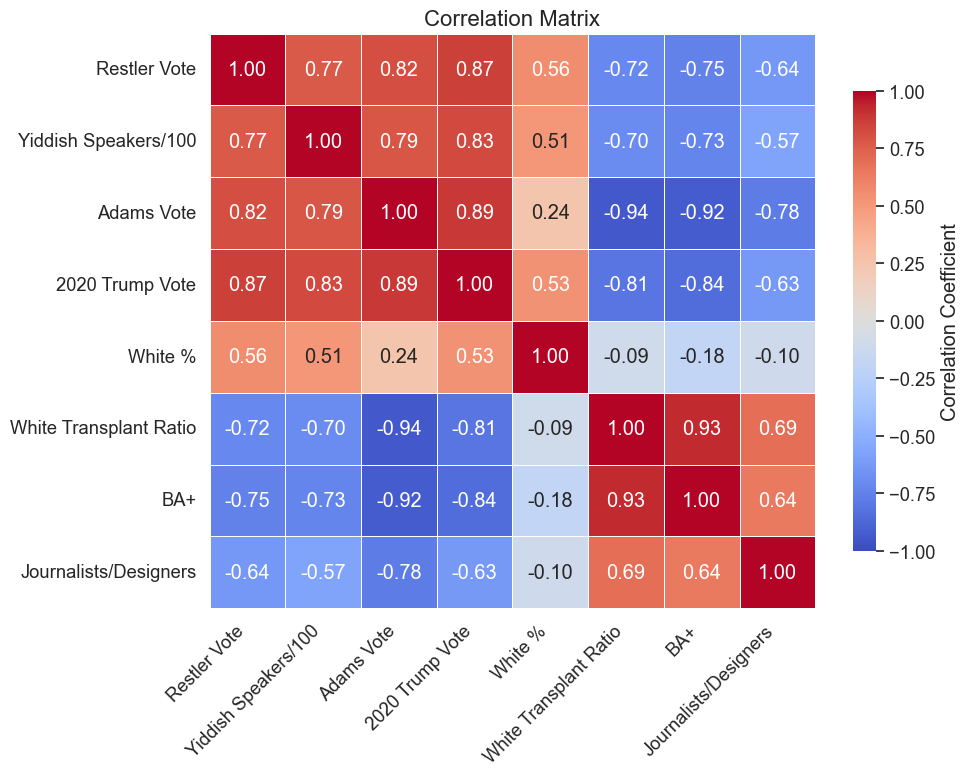

In [12]:
label_map = {
    'vote_share': 'Restler Vote',
    'white_transplant_ratio': 'White Transplant Ratio',
    'pg20djtp': '2020 Trump Vote',
    'nhw21p': 'White %',
    'mhhi21': 'Median HH Income',
    'cvap21bapp': 'BA+',
    'w2admp': 'Journalists/Designers',
    'w2bgp': 'Janitors/Building',
    'w2hsp': 'Home Health Aid',
    'w2cmp': 'Software/Computers',
    'w2govp': 'Government',
    'adams213p' : 'Adams Vote',
    'rateE' : 'Yiddish Speakers/100'
}
cor_cols = ['vote_share','rateE','adams213p','pg20djtp','nhw21p','white_transplant_ratio','cvap21bapp','w2admp'] 
corr_matrix = demo_occ[cor_cols].corr()
corr_matrix.rename(index=label_map, columns=label_map, inplace=True)
plt.figure(figsize=(10, 8))
sns.set(style="white", font_scale=1.2)

heatmap = sns.heatmap(
    corr_matrix,
    annot=True,             
    fmt=".2f",             
    cmap="coolwarm",        
    vmin=-1, vmax=1,        
    linewidths=0.5,         
    cbar_kws={"shrink": 0.8, 'label': 'Correlation Coefficient'}
)

plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [18]:
m2 = smf.ols('vote_share ~ pg20djtp + rateE + w2admp', data=demo_occ).fit(cov_type='HC3')
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     261.0
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           3.82e-53
Time:                        13:34:06   Log-Likelihood:                -478.70
No. Observations:                 127   AIC:                             965.4
Df Residuals:                     123   BIC:                             976.8
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.4697      3.936     10.537      0.0

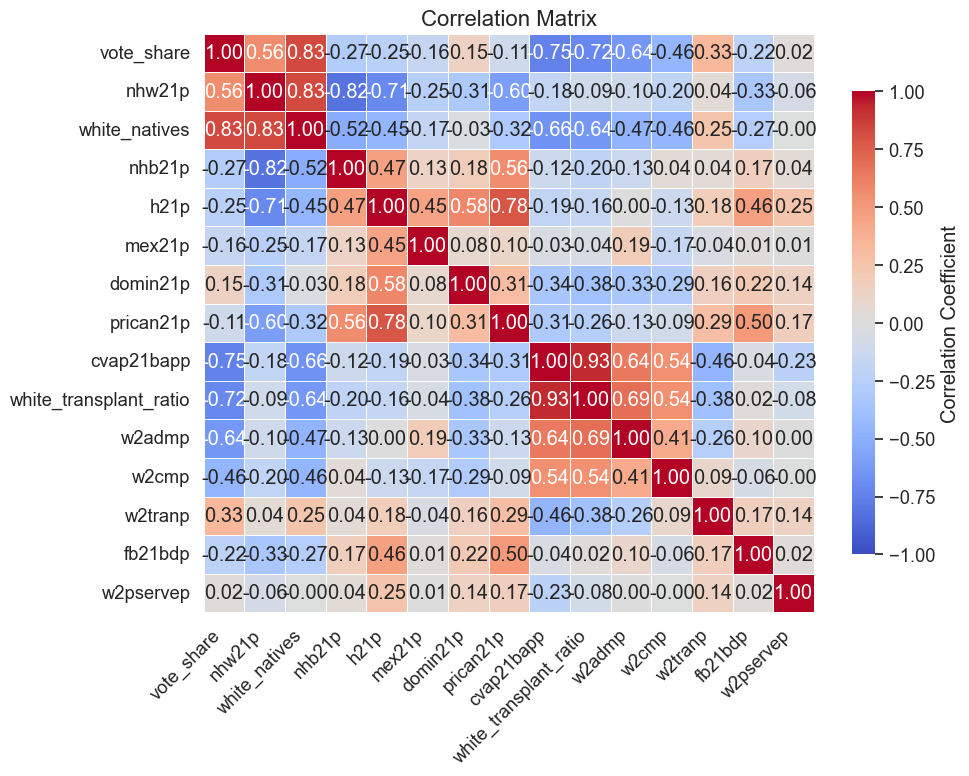

In [12]:
small_cor_cols = ['vote_share','nhw21p','white_natives','nhb21p','h21p','mex21p','domin21p','prican21p','cvap21bapp','white_transplant_ratio','w2admp','w2cmp','w2tranp','fb21bdp','w2pservep']
small_cor_matrix = demo_occ[small_cor_cols].corr()
small_cor_matrix.dropna(subset=('vote_share'),inplace=True) 
#small_cor_matrix.rename(index=label_map, columns=label_map, inplace=True)

plt.figure(figsize=(10, 8))
sns.set(style="white", font_scale=1.2)

heatmap = sns.heatmap(
    small_cor_matrix,
    annot=True,             
    fmt=".2f",             
    cmap="coolwarm",        
    vmin=-1, vmax=1,        
    linewidths=0.5,         
    cbar_kws={"shrink": 0.8, 'label': 'Correlation Coefficient'}
)

plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [70]:
kmo_all, kmo_model = calculate_kmo(demo_occ[test_cols])
chi_square_value, p_value = calculate_bartlett_sphericity(demo_occ[test_cols])

print("KMO per item:", kmo_all)
print("Overall KMO:", kmo_model)       
print("Bartlett’s test χ²:", chi_square_value, "p-value:", p_value) 

KMO per item: [0.73817256 0.76962751 0.38032311 0.24186949 0.35140621 0.41880869
 0.63389585 0.38592795 0.3166333  0.31525625 0.29704508 0.18506259
 0.27385099 0.2582587  0.09426549 0.63849749 0.29402827 0.18388275
 0.12989925 0.48520746 0.6712115  0.16567633 0.1456873  0.40923736
 0.2241216  0.44015405 0.73205861 0.65416953 0.53086541 0.65941269
 0.65814914 0.49222348 0.33377969 0.28836415 0.14953037 0.43283235
 0.52432899 0.76670732 0.67626771 0.10065622 0.54434437 0.29041055
 0.16945887 0.24186047 0.5829042  0.35759715 0.26712575 0.51396899
 0.50569013 0.25671098 0.23901556 0.14112286 0.27331124 0.5035469 ]
Overall KMO: 0.4120418717133485
Bartlett’s test χ²: 9192.797425878674 p-value: 0.0


In [10]:
def iterative_kmo_prune(df, threshold_item=0.50, threshold_overall=0.60):
    from factor_analyzer import calculate_kmo
    df_current = df.copy()
    while True:
        kmo_items, kmo_overall = calculate_kmo(df_current)
        worst_idx = kmo_items.argmin()
        if (kmo_overall >= threshold_overall and 
            all(kmo_items >= threshold_item)):
            break
        drop_var = df_current.columns[worst_idx]
        print(f"Dropping '{drop_var}' (KMO={kmo_items[worst_idx]:.3f}); new overall KMO before recalculation = {kmo_overall:.3f}")
        df_current = df_current.drop(columns=[drop_var])
    return df_current

In [71]:
pruned_df = iterative_kmo_prune(demo_occ[test_cols])

Dropping 'mex21p' (KMO=0.094); new overall KMO before recalculation = 0.412
Dropping 'w2prodp' (KMO=0.113); new overall KMO before recalculation = 0.481
Dropping 'w2htp' (KMO=0.125); new overall KMO before recalculation = 0.528
Dropping 'w2cossp' (KMO=0.249); new overall KMO before recalculation = 0.579
Dropping 'arab21p' (KMO=0.242); new overall KMO before recalculation = 0.579
Dropping 'colomb21p' (KMO=0.246); new overall KMO before recalculation = 0.575
Dropping 'bang21p' (KMO=0.283); new overall KMO before recalculation = 0.599
Dropping 'nhb21p' (KMO=0.325); new overall KMO before recalculation = 0.614
Dropping 'w2pservep' (KMO=0.343); new overall KMO before recalculation = 0.650
Dropping 'w2farmp' (KMO=0.377); new overall KMO before recalculation = 0.666
Dropping 'pak21p' (KMO=0.381); new overall KMO before recalculation = 0.680
Dropping 'w2copp' (KMO=0.393); new overall KMO before recalculation = 0.689
Dropping 'w2tranp' (KMO=0.405); new overall KMO before recalculation = 0.695
D

In [72]:
predictors = pruned_df.columns.tolist()
X = demo_occ[predictors]

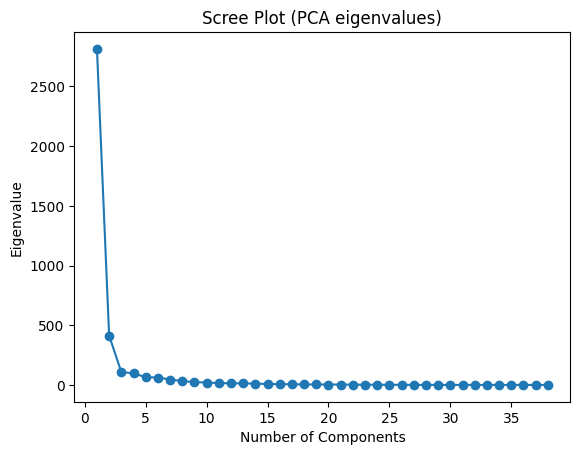

In [73]:
pca = PCA()
pca.fit(X)

ev = pca.explained_variance_

plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.title('Scree Plot (PCA eigenvalues)')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.show()

In [74]:
n_factors = 3
fa = FactorAnalysis(n_components=n_factors, random_state=0)
factor_scores = fa.fit_transform(X)

In [75]:
fa_df = pd.DataFrame(
    factor_scores,
    columns=[f'Factor{i+1}' for i in range(n_factors)],
    index=demo_occ.index
)

In [76]:
loadings = pd.DataFrame(
    fa.components_.T,
    index=predictors,
    columns=fa_df.columns
)
print("Factor Loadings:\n", loadings)

Factor Loadings:
                           Factor1    Factor2   Factor3
pg20djtp                26.036742  -7.257102  1.850373
rateE                   11.281732  -4.106877  2.645916
nhw21p                   4.696141 -14.316531  1.036140
h21p                     0.392413   5.839505 -3.836954
nha21p                  -3.379357   2.452779  3.251602
cvap21bapp             -26.044374  -2.254017  4.207489
log_mhhi21              -1.178583   0.068723 -0.378716
venez21p                -0.154207   0.052943  0.062017
chin21p                 -1.578783   1.564420  2.430455
domin21p                 0.852315   1.366066 -0.330016
prican21p                0.855872   3.214320 -1.974085
white_transplant_ratio -11.120995  -2.208476 -0.550158
ind21p                  -0.702411   0.534320  0.195273
filip21p                -0.139663   0.010289  0.031865
greek21p                -0.149896  -0.026681  0.008299
fb21bdp                 -0.024761   0.149123 -0.083386
fb21drp                  0.403008   0.833420 -0

In [77]:
Y = demo_occ['vote_share']
model_fa = sm.OLS(Y, sm.add_constant(fa_df)).fit()
print(model_fa.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     156.1
Date:                Mon, 29 Sep 2025   Prob (F-statistic):           9.15e-42
Time:                        12:03:14   Log-Likelihood:                -472.46
No. Observations:                 127   AIC:                             952.9
Df Residuals:                     123   BIC:                             964.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.1323      0.900     56.785      0.0

In [42]:
co_3857['white_natives'] = co_3857['nhw21p'] - co_3857['white_transplant_ratio'] 

In [23]:
co_3857 = co_3857.merge(demo_occ[['ed_name','rateE']],on='ed_name',how='left')

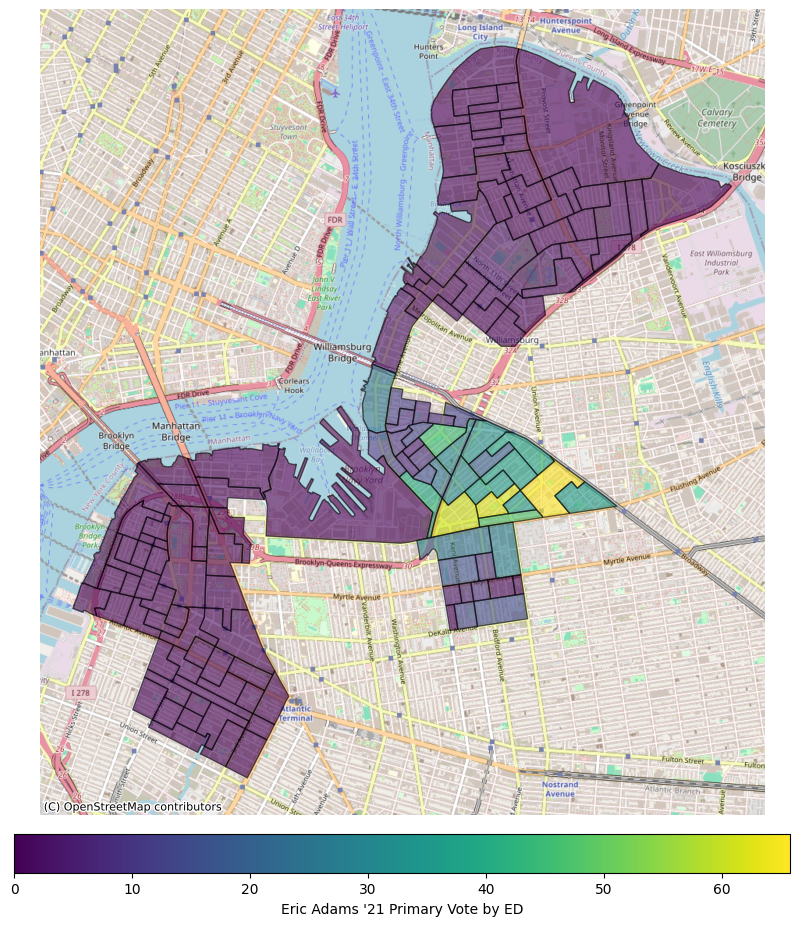

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))
co_3857.plot(
    column= "rateE",
    legend=True,
    legend_kwds={
        "label": "Eric Adams '21 Primary Vote by ED",
        "orientation": "horizontal",
        "shrink": 0.8,        
        "pad": 0.02            
    },
    ax=ax,
    alpha=0.6,
    edgecolor="k",
    cmap="viridis",
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [45]:
demo_occ['white_natives'].describe()

count    127.000000
mean      49.590373
std       21.082158
min        3.389417
25%       35.376422
50%       46.277796
75%       62.906341
max       98.225224
Name: white_natives, dtype: float64

In [ ]:
Y = demo_occ['vote_share']
model1 = sm.OLS(Y, sm.add_constant(demo_occ[['cvap21bapp','w2oadp','w2edup']])).fit()
model2 = sm.OLS(Y, sm.add_constant(demo_occ[['cvap21bapp','w2oadp','w2edup','w2admp']])).fit()
model3 = sm.OLS(Y, sm.add_constant(demo_occ[['cvap21bapp','w2oadp','w2edup','w2admp','rateE']])).fit()
model4 = sm.OLS(Y, sm.add_constant(demo_occ[['cvap21bapp','w2oadp','w2edup','w2admp','rateE','pg20djtp']])).fit()
summary_col([model1,model2,model3,model4],stars=True)

In [50]:
summary_col([model1,model2,model3,model4],stars=True)

<class 'statsmodels.iolib.summary2.Summary'>
"""

========================================================================
               vote_share I vote_share II vote_share III vote_share IIII
------------------------------------------------------------------------
const          49.0714***   54.5756***    53.0601***     42.0145***     
               (7.8455)     (7.8168)      (7.3091)       (6.7107)       
cvap21bapp     -0.2544***   -0.1826**     -0.1330*       0.0046         
               (0.0829)     (0.0838)      (0.0791)       (0.0735)       
w2oadp         0.4528***    0.4056***     0.2258**       0.0118         
               (0.1095)     (0.1073)      (0.1084)       (0.1022)       
w2edup         0.7871**     0.6945**      0.3541         -0.1587        
               (0.3134)     (0.3051)      (0.2956)       (0.2747)       
w2admp                      -0.7486***    -0.6192***     -0.5090**      
                            (0.2486)      (0.2341)       (0.2073)       
rateE                                     0.5550***      0.2381*        
                                          (0.1278)       (0.1247)       
pg20djtp                                                 0.5157***      
                                                         (0.0866)       
R-squared      0.6321       0.6576        0.7038         0.7713         
R-squared Adj. 0.6232       0.6464        0.6915         0.7598         
========================================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

In [58]:
demo_occ.to_csv('../../census_central/dis_33.csv', index=False)

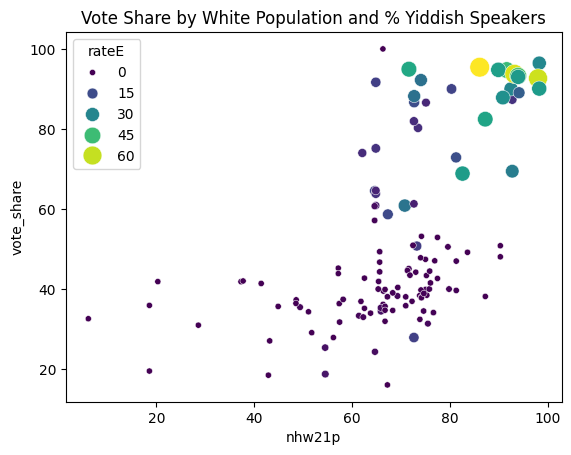

In [59]:
sns.scatterplot(
    data=demo_occ,
    x="nhw21p",        # white population
    y="vote_share",    # dependent variable
    hue="rateE",       # % Yiddish speakers
    palette="viridis", # nice continuous colormap
    size="rateE",      # optional: scale point size by Yiddish %
    sizes=(20, 200)
)

plt.title("Vote Share by White Population and % Yiddish Speakers")
plt.show()

In [78]:
demo_occ['rateE'].describe()

count    127.000000
mean       7.445518
std       14.202081
min        0.000000
25%        0.115098
50%        0.363157
75%        8.199646
max       65.800763
Name: rateE, dtype: float64

In [80]:
demo_occ[demo_occ['rateE'] > 10].shape

(27, 243)

In [33]:
hp = demo_occ[demo_occ['rateE'] > 20]

In [34]:
hasidic_dis = hp['ElectDist'].tolist()

In [90]:
d33 = full_results[full_results['district'] == 33]

In [93]:
d33[~d33['ElectDist_x'].isin(hasidic_dis)].groupby('candidate')['vote_share'].mean().sort_values(ascending=False)

candidate
Lincoln Restler          42.827139
Elizabeth E. Adams       24.083633
Victoria E. Cambranes     8.101354
Sabrina N. Gates          6.849594
Toba Potosky              6.047582
April Somboun             5.598835
Stu Sherman               4.531694
Ben Solotaire             2.635011
217890.0                  2.199116
217802.0                  1.346093
218600.0                  0.840094
Write-in                  0.745979
217576.0                  0.664950
217616.0                  0.582534
overvote                  0.551619
217941.0                  0.538006
218601.0                  0.494614
218139.0                  0.319267
Name: vote_share, dtype: float64

In [92]:
d33.groupby('candidate')['vote_share'].mean().sort_values(ascending=False)

candidate
Lincoln Restler          51.132343
Elizabeth E. Adams       20.491336
Victoria E. Cambranes     7.105268
Sabrina N. Gates          6.230455
Toba Potosky              5.189346
April Somboun             4.944753
Stu Sherman               3.964566
Ben Solotaire             2.453130
217890.0                  2.199116
217802.0                  1.346093
Write-in                  0.845148
218600.0                  0.840094
217576.0                  0.664950
overvote                  0.654886
217616.0                  0.582534
217941.0                  0.538006
218601.0                  0.494614
218139.0                  0.319267
Name: vote_share, dtype: float64

In [9]:
all_rounds

district_33_choice_1   district_33_choice_2 district_33_choice_3  \
0         Elizabeth E. Adams  Victoria E. Cambranes         Toba Potosky   
1         Elizabeth E. Adams           Toba Potosky        Ben Solotaire   
2      Victoria E. Cambranes        Lincoln Restler          Stu Sherman   
3      Victoria E. Cambranes     Elizabeth E. Adams        April Somboun   
4         Elizabeth E. Adams     Elizabeth E. Adams   Elizabeth E. Adams   
...                      ...                    ...                  ...   
29215        Lincoln Restler     Elizabeth E. Adams                  NaN   
29216  Victoria E. Cambranes                    NaN                  NaN   
29217        Lincoln Restler        Lincoln Restler      Lincoln Restler   
29218        Lincoln Restler       Sabrina N. Gates                  NaN   
29219        Lincoln Restler                    NaN                  NaN   

      district_33_choice_4 district_33_choice_5        Precinct  
0            April Somboun     Sabrina N. Gates  AD: 52 ED: 028  
1          Lincoln Restler        April Somboun  AD: 52 ED: 028  
2                      NaN                  NaN  AD: 52 ED: 028  
3            Ben Solotaire      Lincoln Restler  AD: 52 ED: 028  
4       Elizabeth E. Adams   Elizabeth E. Adams  AD: 52 ED: 028  
...                    ...                  ...             ...  
29215                  NaN                  NaN  AD: 50 ED: 057  
29216                  NaN                  NaN  AD: 50 ED: 057  
29217      Lincoln Restler      Lincoln Restler  AD: 50 ED: 058  
29218                  NaN                  NaN  AD: 50 ED: 058  
29219                  NaN                  NaN  AD: 50 ED: 058  

[29220 rows x 6 columns]

In [10]:
all_rounds = make_edname(all_rounds)

In [15]:
choice_cols = [f'district_33_choice_{i}' for i in range(1, 6)]

In [ ]:
def rcv_rounds(df, choice_cols):
    """
    Simulate RCV rounds.
    Returns a DataFrame with one row per round and columns for each candidate's vote count.
    Also includes 'total_active_ballots', 'eliminated' and 'winner' info per round.
    Tie handling: if multiple lowest tied, picks the lexicographically first candidate (deterministic).
    """
    ballots = []
    for _, row in df[choice_cols].iterrows():
        ballot = [str(x).strip() for x in row.tolist() if pd.notna(x) and str(x).strip() != 'nan' and str(x).strip() != '']
        ballots.append(ballot)
    all_candidates = sorted({c for b in ballots for c in b})
    eliminated = set()
    rounds = []
    round_no = 1

    while True:

        counts = {c: 0 for c in all_candidates}
        total_active_ballots = 0
        exhausted = 0

        for b in ballots:
            allocated = False
            for pref in b:
                if pref not in eliminated:
                    counts[pref] += 1
                    total_active_ballots += 1
                    allocated = True
                    break
            if not allocated:
                exhausted += 1


        percents = {c: (counts[c] / total_active_ballots) if total_active_ballots > 0 else 0 for c in counts}

        round_info = {
            'round': round_no,
            'total_active_ballots': total_active_ballots,
            'exhausted_ballots': exhausted,
            'eliminated_this_round': None,
            'winner': None
        }

        for c in all_candidates:
            round_info[f'count__{c}'] = counts[c]
            round_info[f'pct__{c}'] = percents[c]


        winners = [c for c, pct in percents.items() if pct > 0.5]
        if winners:

            winner = max(winners, key=lambda w: percents[w])
            round_info['winner'] = winner
            rounds.append(round_info)
            break


        remaining = [c for c in all_candidates if c not in eliminated]
        if len(remaining) <= 1:
            if remaining:
                round_info['winner'] = remaining[0]
            rounds.append(round_info)
            break

        remaining_counts = {c: counts[c] for c in remaining}
        min_votes = min(remaining_counts.values())
        losers = [c for c, v in remaining_counts.items() if v == min_votes]
        eliminate_candidate = sorted(losers)[0]
        eliminated.add(eliminate_candidate)
        round_info['eliminated_this_round'] = eliminate_candidate

        rounds.append(round_info)
        round_no += 1

    rounds_df = pd.DataFrame(rounds)
    leading = ['round', 'total_active_ballots', 'exhausted_ballots', 'eliminated_this_round', 'winner']
    other_cols = [c for c in rounds_df.columns if c not in leading]
    rounds_df = rounds_df[leading + other_cols]
    return rounds_df


In [35]:
rounds_full = rcv_rounds(all_rounds, choice_cols)

In [36]:
df_filtered = all_rounds[~all_rounds['ed_name'].isin(hasidic_dis)].reset_index(drop=True)
rounds_filtered = rcv_rounds(df_filtered, choice_cols)

In [ ]:
def final_summary(rounds_df):
    last = rounds_df.iloc[-1]
    winner = last['winner']
    total = last['total_active_ballots']
    # collect candidate counts and pct columns from last row
    cand_counts = {col.replace('count__',''): last[col] for col in rounds_df.columns if col.startswith('count__')}
    cand_pcts = {col.replace('pct__',''): last[col] for col in rounds_df.columns if col.startswith('pct__')}
    summary = pd.DataFrame.from_dict({
        'candidate': list(cand_counts.keys()),
        'count': list(cand_counts.values()),
        'pct': [cand_pcts[c] for c in cand_counts.keys()]
    }).sort_values('count', ascending=False).reset_index(drop=True)
    return {'winner': winner, 'total_active_ballots': total, 'table': summary}

In [37]:
summary_full = final_summary(rounds_full)
summary_filtered = final_summary(rounds_filtered)

In [38]:
print("FULL DATASET final winner:", summary_full['winner'])
print(summary_full['table'].head(10))
print("\nFILTERED DATASET final winner:", summary_filtered['winner'])
print(summary_filtered['table'].head(10))

FULL DATASET final winner: Lincoln Restler
               candidate  count       pct
0        Lincoln Restler  14567  0.503074
1     Elizabeth E. Adams   6278  0.216812
2  Victoria E. Cambranes   2126  0.073422
3       Sabrina N. Gates   1646  0.056845
4           Toba Potosky   1629  0.056258
5          April Somboun   1512  0.052217
6            Stu Sherman   1198  0.041373
7          Ben Solotaire      0  0.000000
8               Write-in      0  0.000000
9               overvote      0  0.000000

FILTERED DATASET final winner: Lincoln Restler
               candidate  count       pct
0        Lincoln Restler  12160  0.511440
1     Elizabeth E. Adams   7044  0.296265
2  Victoria E. Cambranes   2507  0.105442
3       Sabrina N. Gates   2065  0.086852
4          April Somboun      0  0.000000
5          Ben Solotaire      0  0.000000
6            Stu Sherman      0  0.000000
7           Toba Potosky      0  0.000000
8               Write-in      0  0.000000
9               overvote   

In [25]:

def rounds_to_long_counts(rounds_df):
    # collect candidate count columns
    count_cols = [c for c in rounds_df.columns if c.startswith('count__')]
    long_list = []
    for _, r in rounds_df.iterrows():
        for cc in count_cols:
            cand = cc.replace('count__','')
            long_list.append({
                'round': int(r['round']),
                'candidate': cand,
                'count': int(r[cc])
            })
    return pd.DataFrame(long_list)


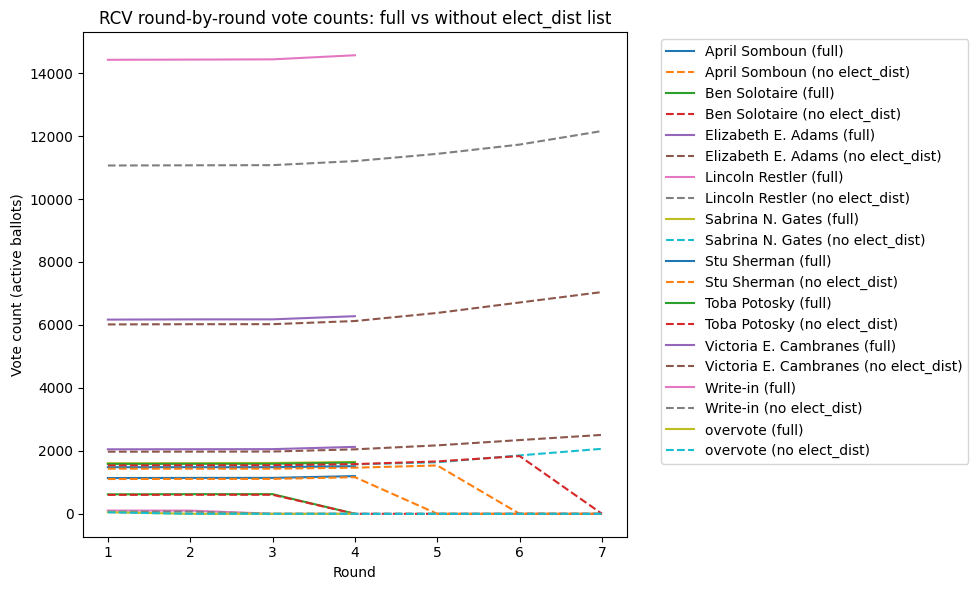

In [39]:

long_full = rounds_to_long_counts(rounds_full)
long_filtered = rounds_to_long_counts(rounds_filtered)

# union of candidates
candidates = sorted(set(long_full['candidate']).union(set(long_filtered['candidate'])))

plt.figure(figsize=(10,6))
for cand in candidates:
    d_full = long_full[long_full['candidate'] == cand]
    d_filtered = long_filtered[long_filtered['candidate'] == cand]
    if not d_full.empty:
        plt.plot(d_full['round'], d_full['count'], label=f"{cand} (full)", linestyle='-')
    if not d_filtered.empty:
        plt.plot(d_filtered['round'], d_filtered['count'], label=f"{cand} (no elect_dist)", linestyle='--')

plt.xlabel('Round')
plt.ylabel('Vote count (active ballots)')
plt.title('RCV round-by-round vote counts: full vs without elect_dist list')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [21]:
demo_occ_map = gpd.GeoDataFrame(demo_occ,geometry=demo_occ['geometry_x'].apply(wkt.loads))

In [22]:
gdf = demo_occ_map.copy()

In [23]:
eth_cols = ['ind21p','bang21p','domin21p','venez21p','mex21p','white_transplant_ratio','winda21p']
red_eth_cols = ['nhw21p','nhb21p','h21p','nha21p']

In [24]:
gdf['laptop'] = gdf['w2admp'] + gdf['w2banp'] + gdf['w2cmp']

gdf['dom_eth']   = gdf[eth_cols].idxmax(axis=1)  
gdf['dom_eth_p'] = gdf[eth_cols].max(axis=1)     

gdf['dom_red_eth']   = gdf[red_eth_cols].idxmax(axis=1)
gdf['dom_red_eth_p'] = gdf[red_eth_cols].max(axis=1)

gdf['dom_occ']   = gdf[wp_cols].idxmax(axis=1)
gdf['dom_occ_p'] = gdf[wp_cols].max(axis=1)

In [46]:
def make_distinct_colormap(categories, palette_name='tab20'):
    """
    Returns dict mapping each category to a hex color, 
    drawn from Matplotlib’s qualitative palette.
    """
    n = len(categories)
    # grab n distinct colors from the palette
    palette = plt.get_cmap(palette_name).colors
    if n > len(palette):
        raise ValueError(f"Palette {palette_name} only has {len(palette)} colors")
    colors = palette[:n]
    return dict(zip(categories, (to_hex(c) for c in colors)))

eth_colors = make_distinct_colormap(sorted(gdf['dom_eth'].unique()), 'tab20')
occ_colors = make_distinct_colormap(sorted(gdf['dom_occ'].unique()), 'tab20')

# 2) map them into new columns on your GeoDataFrame
gdf['eth_color'] = gdf['dom_eth'].map(eth_colors)
gdf['occ_color'] = gdf['dom_occ'].map(occ_colors)

def pct_to_color(hue, pct):
    """
    Convert hue [0–1] & pct [0–100] to an RGB hex.
    We fix saturation=0.7 and vary value/lightness between 0.4 and 1.
    """
    sat = 0.7
    # map 0–100 → 0.4–1.0
    val = 0.4 + 0.6*(pct/100)
    r, g, b = colorsys.hsv_to_rgb(hue, sat, val)
    return (r, g, b)

In [25]:
gdf = gdf.set_crs(epsg=2263, allow_override=True)
gdf_3857 = gdf.to_crs(epsg=3857)

In [48]:
occ_label_map = {
    'w2admp': 'Designers & Journalists',
    'w2banp': 'Analyst Specialist',
    'w2bgp': 'Janitorial',
    'w2conp': 'Construction',
    'w2copp': 'Law Enforcement',
    'w2foodp': 'Food Service',
    'w2hsp': 'Homecare',
    'w2mgtp': 'Management',
    'w2oadp': 'Office Admin',
    'w2salep': 'Sales'
}

gdf_3857['occupation_label'] = gdf_3857['dom_occ'].map(occ_label_map)
gdf_3857['occupation_label'] = gdf_3857['occupation_label'].astype('category')

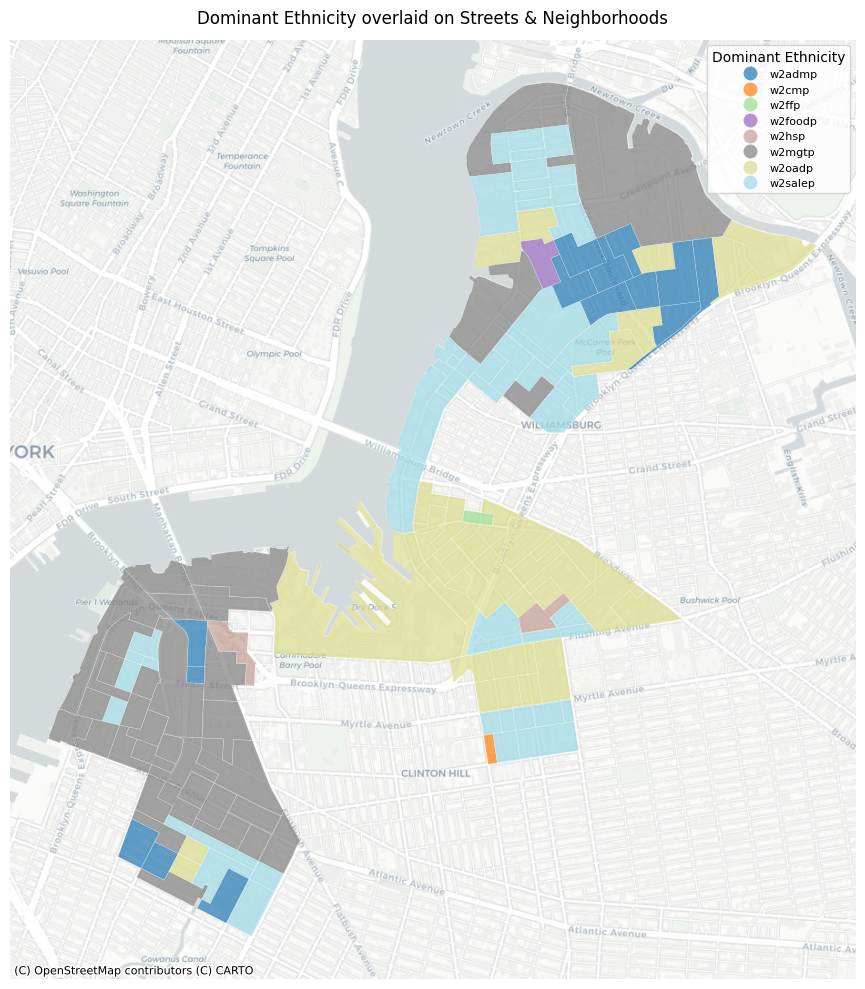

In [49]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf_3857.plot(
    column='dom_occ',
    categorical=True,
    cmap='tab20',
    legend=True,
    alpha=0.7,
    ax=ax,
    edgecolor='white',
    linewidth=0.2,
    legend_kwds={'title': 'Dominant Ethnicity', 'fontsize': 8, 'title_fontsize': 10}
)


ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Positron,  
    zoom=14   
)

# 5) Clean up
ax.set_axis_off()
ax.set_title("Dominant Ethnicity overlaid on Streets & Neighborhoods", pad=12)

plt.tight_layout()
plt.show()

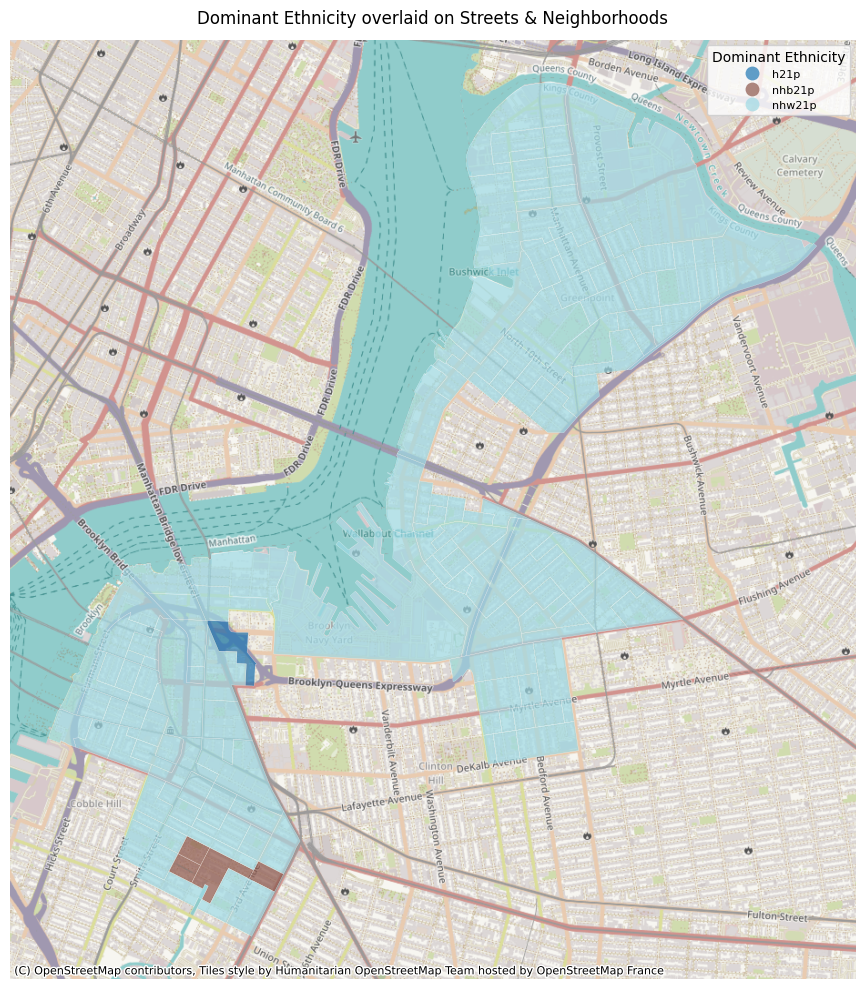

In [53]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf_3857.plot(
    column='dom_red_eth',
    categorical=True,
    cmap='tab20',
    legend=True,
    alpha=0.7,
    ax=ax,
    edgecolor='white',
    linewidth=0.2,
    legend_kwds={'title': 'Dominant Ethnicity', 'fontsize': 8, 'title_fontsize': 10}
)

ctx.add_basemap(
    ax,
    #source=ctx.providers.CartoDB.Positron,  
    zoom=14   
)

ax.set_axis_off()
ax.set_title("Dominant Ethnicity overlaid on Streets & Neighborhoods", pad=12)

plt.tight_layout()
plt.show()

In [57]:
all_rounds

district_33_choice_1   district_33_choice_2 district_33_choice_3  \
0         Elizabeth E. Adams  Victoria E. Cambranes         Toba Potosky   
1         Elizabeth E. Adams           Toba Potosky        Ben Solotaire   
2      Victoria E. Cambranes        Lincoln Restler          Stu Sherman   
3      Victoria E. Cambranes     Elizabeth E. Adams        April Somboun   
4         Elizabeth E. Adams     Elizabeth E. Adams   Elizabeth E. Adams   
...                      ...                    ...                  ...   
29215        Lincoln Restler     Elizabeth E. Adams                  NaN   
29216  Victoria E. Cambranes                    NaN                  NaN   
29217        Lincoln Restler        Lincoln Restler      Lincoln Restler   
29218        Lincoln Restler       Sabrina N. Gates                  NaN   
29219        Lincoln Restler                    NaN                  NaN   

      district_33_choice_4 district_33_choice_5        Precinct  AD   ED  \
0            April Somboun     Sabrina N. Gates  AD: 52 ED: 028  52  028   
1          Lincoln Restler        April Somboun  AD: 52 ED: 028  52  028   
2                      NaN                  NaN  AD: 52 ED: 028  52  028   
3            Ben Solotaire      Lincoln Restler  AD: 52 ED: 028  52  028   
4       Elizabeth E. Adams   Elizabeth E. Adams  AD: 52 ED: 028  52  028   
...                    ...                  ...             ...  ..  ...   
29215                  NaN                  NaN  AD: 50 ED: 057  50  057   
29216                  NaN                  NaN  AD: 50 ED: 057  50  057   
29217      Lincoln Restler      Lincoln Restler  AD: 50 ED: 058  50  058   
29218                  NaN                  NaN  AD: 50 ED: 058  50  058   
29219                  NaN                  NaN  AD: 50 ED: 058  50  058   

       ed_name  
0        52028  
1        52028  
2        52028  
3        52028  
4        52028  
...        ...  
29215    50057  
29216    50057  
29217    50058  
29218    50058  
29219    50058  

[29220 rows x 9 columns]

In [11]:
all_rounds.groupby('district_33_choice_1')['district_33_choice_2'].value_counts(dropna = False).reset_index(name='count').sort_values(by = 'count',ascending=False).head(10)

district_33_choice_1   district_33_choice_2  count
33        Lincoln Restler                    NaN   7272
34        Lincoln Restler     Elizabeth E. Adams   3559
22     Elizabeth E. Adams        Lincoln Restler   2120
23     Elizabeth E. Adams                    NaN   1313
35        Lincoln Restler  Victoria E. Cambranes    955
24     Elizabeth E. Adams  Victoria E. Cambranes    915
36        Lincoln Restler            Stu Sherman    697
37        Lincoln Restler           Toba Potosky    583
76  Victoria E. Cambranes     Elizabeth E. Adams    561
38        Lincoln Restler          April Somboun    551

In [12]:
second_choice = all_rounds.groupby(['ed_name','district_33_choice_1'])['district_33_choice_2'].value_counts(dropna=False).reset_index(name='count')

In [13]:
def aggregate_precinct_counts(df):
    mask_lr_ea = (df['district_33_choice_1'] == "Lincoln Restler") & (df['district_33_choice_2'] == "Elizabeth E. Adams")
    mask_lr_notea = (df['district_33_choice_1'] == "Lincoln Restler") & (df['district_33_choice_2'] != "Elizabeth E. Adams")
    mask_ea_lr = (df['district_33_choice_1'] == "Elizabeth E. Adams") & (df['district_33_choice_2'] == "Lincoln Restler")
    mask_ea_notlr = (df['district_33_choice_1'] == "Elizabeth E. Adams") & (df['district_33_choice_2'] != "Lincoln Restler")
    mask_neither = (df['district_33_choice_1'] != "Elizabeth E. Adams") & (df['district_33_choice_1'] != "Lincoln Restler")
    

    df['lr_ea'] = df['count'] * mask_lr_ea.astype(int)
    df['lr_notea'] = df['count'] * mask_lr_notea.astype(int)
    df['ea_lr'] = df['count'] * mask_ea_lr.astype(int)
    df['ea_notlr'] = df['count'] * mask_ea_notlr.astype(int)
    df['neither'] = df['count'] * mask_neither.astype(int)

    result = df.groupby('ed_name')[['lr_ea', 'lr_notea', 'ea_lr', 'ea_notlr','neither']].sum().reset_index()
    
    return result

In [14]:
ag = aggregate_precinct_counts(second_choice)

In [15]:
def find_biggest_col(row):
    return row.idxmax()

In [16]:
ag['biggest'] = ag[['lr_ea', 'lr_notea', 'ea_lr', 'ea_notlr']].apply(find_biggest_col, axis=1)

In [17]:
ag['total'] = ag['lr_ea'] + ag['lr_notea'] + ag['ea_lr'] + ag['ea_notlr'] + ag['neither']

In [18]:
ag['share_lr_not_ea'] = ((ag['lr_notea'] / ag['total']) * 100).round()

In [26]:
gdf_3857 = gdf_3857.merge(ag,on='ed_name',how='left')

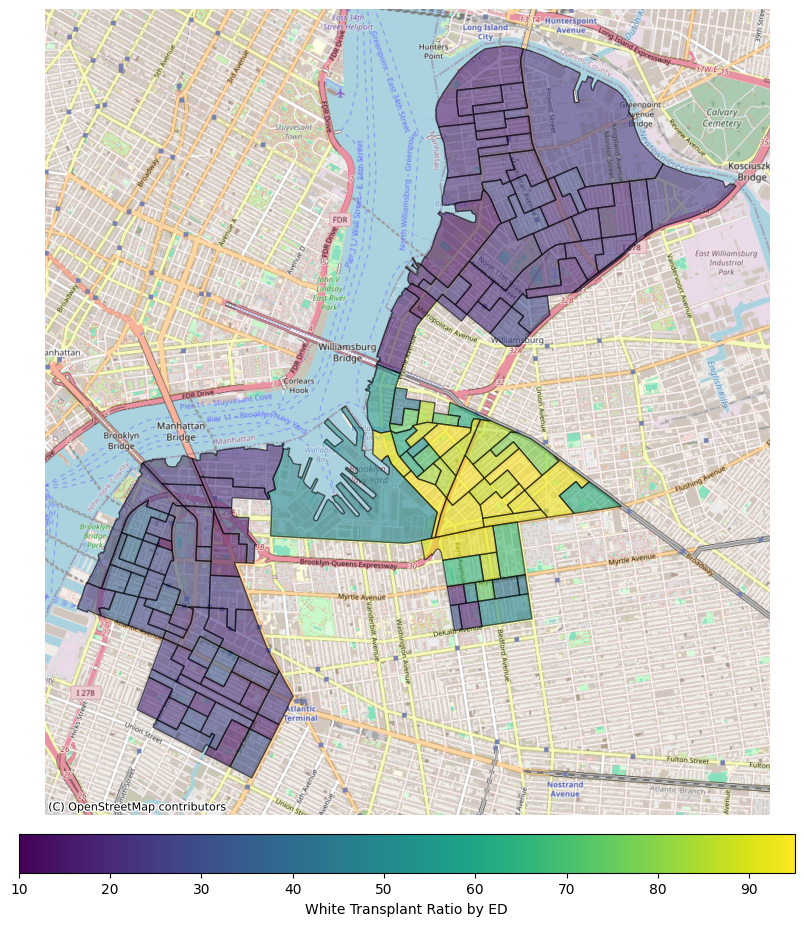

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_3857.plot(
    column='share_lr_not_ea',
    legend=True,
    legend_kwds={
        "label": "White Transplant Ratio by ED",
        "orientation": "horizontal",
        "shrink": 0.8,         # fraction of original size
        "pad": 0.02            # space between map and bar
    },
    ax=ax,
    alpha=0.6,
    edgecolor="k",
    cmap="viridis",
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.tight_layout()
plt.show()

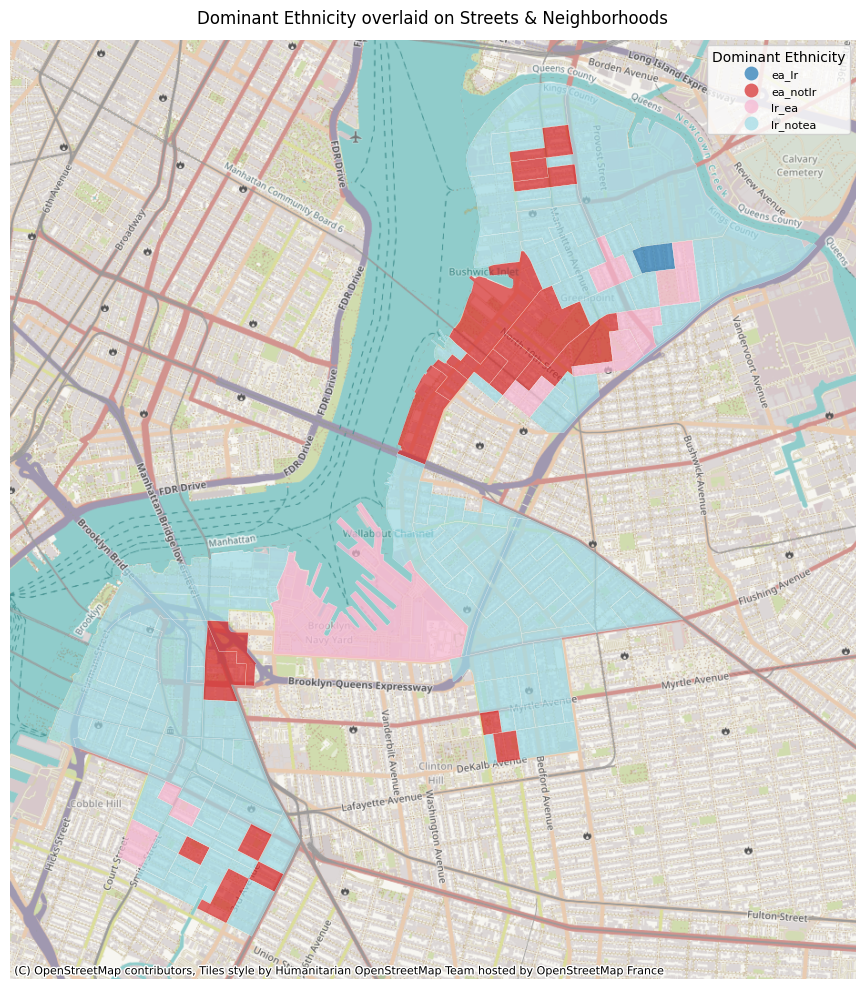

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf_3857.plot(
    column='biggest',
    categorical=True,
    cmap='tab20',
    legend=True,
    alpha=0.7,
    ax=ax,
    edgecolor='white',
    linewidth=0.2,
    legend_kwds={'title': 'Dominant Ethnicity', 'fontsize': 8, 'title_fontsize': 10}
)

ctx.add_basemap(
    ax,
    #source=ctx.providers.CartoDB.Positron,  
    zoom=14   
)

ax.set_axis_off()
ax.set_title("Dominant Ethnicity overlaid on Streets & Neighborhoods", pad=12)

plt.tight_layout()
plt.show()